In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


# create data VGG
## import libraries

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, ActivityRegularization, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Conv1D, MaxPooling1D, TimeDistributed
from keras.layers import AveragePooling2D, Input
from keras.utils import np_utils, normalize
from keras.engine import InputLayer
from keras import backend as K

import os
import h5py
import time

import sklearn
from sklearn.preprocessing import normalize
import random

from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import math

Using TensorFlow backend.


## modifiable variables

In [0]:
# dataset's name 
doc = 'cancer_cells'
# if the dataset is splited
is_splited = True

# paths to load datasets and to save the model
dir_path = 'drive/My Drive/medical_image_recognition/datasets/'
model_path = 'drive/My Drive/medical_image_recognition/models/'


# model
load_model = False
# model type name and weights' path
model_name = 'vgg19' # vgg19, vgg19custom, vgg16, vgg16custom
model_file_name = 'vgg19_best.hdf5'

print('Done')

Done


## file path check

In [0]:
dir_path_DataSet = dir_path + doc + '/'
model_file_path = model_path + doc + '/' + model_file_name
  
if load_model:
  if not os.path.exists(model_file_path):
    print('model file not existe')
  else:
    print('Done')

## image process functions

In [0]:
def read_dir(dir_path):
  """return the differents categories, the images in these categories, and the number of images per category"""
  listDir = sorted(os.listdir(dir_path))
  size = 0
  listFiles = []
  Y = []
  for d in listDir :
    files = sorted(os.listdir(dir_path+'/'+d))
    size += len(files)
    files = [dir_path+'/'+d+'/'+f for f in files]
    listFiles += files
  return listFiles

def dir_train_test_split(listFiles, Y):
  random.seed(42)
  test_index = random.sample(list(range(len(listFiles))), int(test_size*len(listFiles)))
  train_index = [x for x in list(range(len(listFiles))) if x not in test_index]
  
  listFiles_train = [listFiles[i] for i in train_index]
  listFiles_test = [listFiles[i] for i in test_index]
  Y_train = [Y[i] for i in train_index]
  Y_test = [Y[i] for i in test_index]
  return listFiles_train, Y_train, listFiles_test, Y_test

def get_features(file):
  """for all the images in listFiles, extract the features thanks to the network"""
  """return a 4-dimensional array with a 3-dimensional array per image"""
  img = image.load_img(file, target_size=(224 + 320*n, 224 + 320*n))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  del img
  del x
  return features[0,:]

def to_fully_conv(model):
  """transforms the Convolutional Neural Network model into a Fully Convolutional Network"""

  new_model = Sequential()
  input_layer = InputLayer(input_shape=(None, None, 3), name="input_new")
  new_model.add(input_layer)

  for layer in model.layers:

    if "Flatten" in str(layer):
      flattened_ipt = True
      f_dim = layer.input_shape
      continue

    elif "Dense" in str(layer):

      input_shape = layer.input_shape
      output_dim =  layer.get_weights()[1].shape[0]
      W,b = layer.get_weights()

      if flattened_ipt:
          shape = (f_dim[1],f_dim[2],f_dim[3],output_dim)
          new_W = W.reshape(shape)
          aa = np.array([new_W,b])
          new_layer = Convolution2D(output_dim,(f_dim[1],f_dim[2]),
                                    activation=layer.activation,
                                    padding='valid', weights=[new_W,b])
          flattened_ipt = False

      else:
          shape = (1,1,input_shape[1],output_dim)
          new_W = W.reshape(shape)
          new_layer = Convolution2D(output_dim,(1,1),
                                    activation=layer.activation,
                                    padding='valid', weights=[new_W,b])
    else:
      new_layer = layer
    new_model.add(new_layer)
    
  return new_model

## custom neural network definition

In [0]:
def get_cnn_model(model_name: str):
    """
    TODO
    """
    if model_name == 'vgg16':
        return create_vgg16()
    elif model_name == 'vgg16custom':
        return create_vgg16custom()
    elif model_name == 'vgg19':
        return create_vgg19()
    elif model_name == 'vgg19custom':
        return create_vgg19custom()
    else:
        raise ValueError(
                'The model {} isn\'t implemented yet'.format(model_name))

################################################################################
def create_vgg16():
    """
    TODO
    """
    base_model = VGG16(include_top=False,
                             weights='imagenet',
                             input_shape=(HEIGHT, WIDTH, CHANNELS))

    model = Sequential()
    model.add(base_model)

    # add classification block
    model.add(Flatten(name='flatten'))
    model.add(Dense(1024, activation='relu', name='fc1'))
    model.add(Dropout(0.7, name='dropout1'))
    model.add(Dense(512, activation='relu', name='fc2'))
    model.add(Dropout(0.5, name='dropout2'))
    model.add(Dense(NUM_LABELS, activation='softmax', name='predictions'))

    # see the base model architecture
    #base_model.summary()

    return model

################################################################################
def create_vgg16custom():
    """
    TODO
    """
    img_input = Input(shape=(HEIGHT, WIDTH, CHANNELS), name='ImageInput')

    # block 1
    x = Conv2D(64, (3, 3),
               activation='relu',
               padding='same',
               name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3),
               activation='relu',
               padding='same',
               name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), name='block1_pool')(x)

    #TODO
    # variables to change for SeparableConv2D
    # no activation in xception
    # use_bias=False

    # block 2
    x = SeparableConv2D(128, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block2_conv1')(x)
    x = SeparableConv2D(128, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), name='block2_pool')(x)

    # block 3
    x = SeparableConv2D(256, (3, 3),
                        activation='relu',
                        padding='same',
                        #use_bias=False,
                        name='block3_conv1')(x)
    x = BatchNormalization(name='block3_conv1_bn')(x)
    x = SeparableConv2D(256, (3, 3),
                        activation='relu',
                        padding='same',
                        #use_bias=False,
                        name='block3_conv2')(x)
    x = BatchNormalization(name='block3_conv2_bn')(x)
    x = SeparableConv2D(256, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), name='block3_pool')(x)

    # block 4
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block4_conv1')(x)
    x = BatchNormalization(name='block4_conv1_bn')(x)
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block4_conv2')(x)
    x = BatchNormalization(name='block4_conv2_bn')(x)
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), name='block4_pool')(x)

    # block 5
    # TODO

    # classification block
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x) #4096
    x = Dropout(0.7, name='dropout1')(x) # not present
    x = Dense(512, activation='relu', name='fc2')(x) # 4096
    x = Dropout(0.5, name='dropout2')(x) # not present
    x = Dense(NUM_LABELS, activation='softmax', name='predictions')(x)

    # create the cnn
    model = Model(img_input, x, name='vgg16_custom')

    # !!! WEIGHTS !!!
    weights_path = MODEL_PATH + 'weights_notop.h5'
    print('Trying to load weights from {} ...'.format(weights_path))
    
    ### TODO cleaner
    from pathlib import Path
    weights_path = Path(weights_path)
    if not weights_path.is_file():
        vgg16_model = VGG16(weights='imagenet', include_top=False)
        vgg16_model.save_weights(weights_path)

    # load weights
    model.load_weights(weights_path, by_name=True)
    print('DONE')
    return model

################################################################################
def create_vgg19():
    """
    TODO
    """
    base_model = VGG19(include_top=False,
                             weights='imagenet',
                             input_shape=(HEIGHT, WIDTH, CHANNELS))

    model = Sequential()
    model.add(base_model)

    # add classification block
    model.add(Flatten(name='flatten'))
    model.add(Dense(1024, activation='relu', name='fc1'))
    model.add(Dropout(0.7, name='dropout1'))
    model.add(Dense(512, activation='relu', name='fc2'))
    model.add(Dropout(0.5, name='dropout2'))
    model.add(Dense(NUM_LABELS, activation='softmax', name='predictions'))

    #base_model.summary()
    #model.summary()

    return model

################################################################################
def create_vgg19custom():
    """
    TODO
    """
    
    #TODO
    # variables to change for SeparableConv2D
    # no activation in xception
    # use_bias=False
    
    img_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    # block 1
    # it's exactly the same as in vgg19
    x = Conv2D(64, (3, 3),
               activation='relu',
               padding='same',
               name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3),
               activation='relu',
               padding='same',
               name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # block 2
    x = SeparableConv2D(128, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block2_conv1')(x)
    x = SeparableConv2D(128, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), name='block2_pool')(x)

    # block 3
    x = SeparableConv2D(256, (3, 3),
                        activation='relu',
                        padding='same',
                        #use_bias=False,
                        name='block3_conv1')(x)
    x = BatchNormalization(name='block3_conv1_bn')(x)
    x = SeparableConv2D(256, (3, 3),
                        activation='relu',
                        padding='same',
                        #use_bias=False,
                        name='block3_conv2')(x)
    x = BatchNormalization(name='block3_conv2_bn')(x)
    x = SeparableConv2D(256, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), name='block3_pool')(x)

    # block 4
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block4_conv1')(x)
    x = BatchNormalization(name='block4_conv1_bn')(x)
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block4_conv2')(x)
    x = BatchNormalization(name='block4_conv2_bn')(x)
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), name='block4_pool')(x)

    # block 5
    # TODO

    # classification block
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x) #4096
    x = Dropout(0.7, name='dropout1')(x) # not present
    x = Dense(512, activation='relu', name='fc2')(x) # 4096
    x = Dropout(0.5, name='dropout2')(x) # not present
    x = Dense(NUM_LABELS, activation='softmax', name='predictions')(x)

    #TODO load weights here

    model = Model(img_input, x, name='vgg19custom')
    return model

## prepare data

In [0]:
#split train test examples
def get_list_files():
  if is_splited:
    dir_path_test =  dir_path_DataSet + 'test/'
    listFiles = read_dir(dir_path_test)

  else:
    listFiles = read_dir(dir_path_DataSet)
  return listFiles  

## generate vectors and save in files

In [0]:
def visualise_features(file, layer):
  X = get_features(file)
  h,w,n = X.shape
  print(X.shape)
  c = math.ceil(math.sqrt(n))
  X_ = np.zeros((h*c, w*c))
  for i in range(c):
    for j in range(c):
      if i*c+j >= n:
        break
      X_[i*h:(i+1)*h,j*w:(j+1)*w] = X[:,:,i*c+j]
  plt.figure(figsize = (10,10))
  plt.imshow(X_)
  return X_

def visualise_feature(file, layer):
  X = get_features(file)
  
#   plt.figure(figsize = (15,15))
  plt.imshow(X[:,:,0])
  return X

def visualise_image(file):
  
  img = cv2.imread(file)
  res = cv2.resize(img, dsize=(224 + 320*n, 224 + 320*n), interpolation=cv2.INTER_CUBIC)
  
  plt.imshow(img)
  plt.show()
    
def get_model(layer):
  if load_model:
    network = get_cnn_model(model_name)
    network.load_weights(model_file_path)
  else:
    network = VGG19(weights='imagenet')
  model = Model(inputs=network.input, outputs=network.get_layer(layer).get_output_at(-1))
  if n >= 1 : 
    model = to_fully_conv(model)
  return model

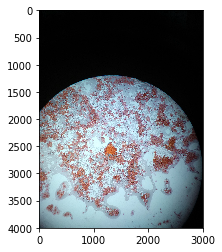

(14, 14, 512)
Done


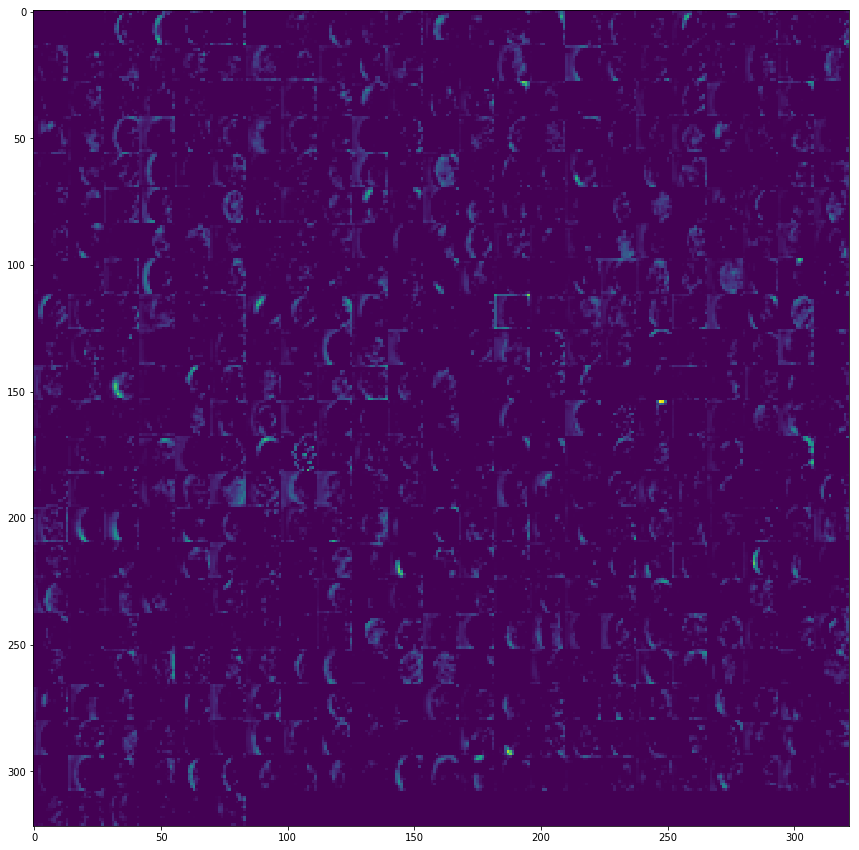

In [0]:
# feature extraction parameters
scales=[0]
layers=['block5_conv1']

for layer in layers:
  for n in scales: 
    listFiles = get_list_files()
    model = get_model(layer)
    file = listFiles[0]
    if not isinstance(file, str):
      file = file[0]
    visualise_image(file)
    X = visualise_features(file, layer)
print('Done')